# Práctica 4 - Filtrado de Spam usando Bayes Ingenuo

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe de la práctica. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para la P4 con el nombre NIP_P4.ipynb

La evaluación de la práctica se realizará mediante una entrevista durante el desarrollo de la práctica 5 en la que se deberá mostrar el funcionamiento del cuaderno de Colab y resolver a preguntas relacionadas con su contenido. Evaluación: funcionamiento de colab 50%. Respuesta a las preguntas 50% de la nota.

Imports necesarios para ejecutar la práctica

In [1]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

Carga del fichero ZIP con todos los correos

In [2]:
!gdown 1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8
!unzip -q "enron.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8
From (redirected): https://drive.google.com/uc?id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8&confirm=t&uuid=5841c1ec-5d8f-43ac-a0cd-611ffe17cffc
To: /content/enron.zip
100% 28.9M/28.9M [00:00<00:00, 99.0MB/s]


Lectura de los emails y carga en las estructuras de datos

In [3]:
def read_folder(folder):
    mails = []
    file_list = glob.glob(folder)  # Listar archivos en la carpeta
    num_files = len(file_list)
    for i in range(0, num_files):
        i_path = file_list[i]
        i_file = open(i_path, 'rb')
        i_str = i_file.read()
        i_text = i_str.decode('utf-8', errors='ignore')  # Convert to Unicode
        mails.append(i_text)  # Append to the mail structure
        i_file.close()
    return mails

def load_enron_folders(datasets):
    path = './'
    ham = []  # correos ham
    spam = [] # correos spam
    for j in datasets:
        ham  = ham  + read_folder(path + '/enron' + str(j) + '/ham/*.txt')
        spam = spam + read_folder(path + '/enron' + str(j) + '/spam/*.txt')
    num_ham  = len(ham)
    num_spam = len(spam)
    print("mails:", num_ham+num_spam)
    print("ham  :", num_ham)
    print("spam :", num_spam)

    mails = ham + spam
    labels = [0]*num_ham + [1]*num_spam
    mails, labels = shuffle(mails, labels, random_state=0)  # Mezclar datos aleatoriamente
    return mails, labels

print("Loading files...")

print("------Loading train and validation data--------")
mails, y = load_enron_folders([1,2,3,4,5])

# Divide en 80% para entrenamiento y 20% para validación.
mails_train, mails_val, y_train, y_val = train_test_split(mails, y, train_size = 0.8)

print("--------------Loading test data----------------")
mails_test, y_test = load_enron_folders([6])

Loading files...
------Loading train and validation data--------
mails: 27716
ham  : 15045
spam : 12671
--------------Loading test data----------------
mails: 6000
ham  : 1500
spam : 4500


Código para generar una bolsa de palabras que cuenta el número de apariciones de cada palabra en la lista de correos

Crea una matriz X con tantas filas como correos (27716) y tantas columnas como palabras de la BD. El elemento (i,j) de la matriz contiene el número de ocurrencias de la palabra j en el correo i

BERNOULLI, UNIGRAMAS:

In [4]:
porcentajeTotal = 0.0
alphaFinal = 0.0
mejorAlphaLocal = 0.0
mejorPorcentajeLocal =0.0

# Crea un vectorizador para convertir texto a características numéricas como unigramas
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit se encarga de crear el vocabulario con todas las palabras únicas presentes en los datos de entrada
# Transform se encarga de transformar los datos de entrada en un vector (numérico, para que el modelo pueda entender)
X = vectorizer.fit_transform(mails_train)

# Transform se encarga de transformar los datos previamente aprendidos en un vector con el mismo vocabulario
X_val = vectorizer.transform(mails_val)

# Bucle para comprobar el alpha desde 0.1 hasta 1.0, yendo de 0.01 en 0.01 para obtener el mejor
for i in np.arange(0.1,1.0,0.01):
  # Se crea un clasificador Bayesiano Ingenuo con distribución de Bernoulli y el valor actual alpha
  classifier = BernoulliNB(alpha=i, fit_prior=True, class_prior=None)

  # Entrena el modelo con los datos de entrenamiento
  classifier.fit(X,y_train)

  # Predice etiquetas para los datos de validación
  y_pred = classifier.predict(X_val)

  # Calcula el F1-score (métrica de evaluación) para las predicciones
  f1_score=metrics.f1_score(y_val, y_pred)

  porcentaje = 100*f1_score
  #print(f"Porcentaje: {porcentaje:.2f}%", end=" \n")

  if (porcentaje > porcentajeTotal):
      opcion_elegida="Bernoulli con unigrama"
      alphaFinal = i

  if (porcentaje > mejorPorcentajeLocal):
    mejorPorcentajeLocal = porcentaje
    mejorAlphaLocal = i
    if (mejorPorcentajeLocal > porcentajeTotal):
        porcentajeTotal = mejorPorcentajeLocal
        opcion_elegida="Bernoulli con unigrama"
        alphaFinal = i

Con el alpha más adecuado:

BERNOUILLI CON UNIGRAMAS

El alpha utilizado es: 0.1000 
F1-score of the test: 98.55%
Confusion Matrix:
[[2955   60]
 [  14 2515]]


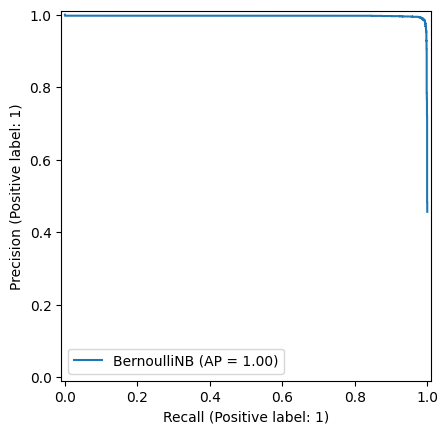

In [5]:
print("BERNOUILLI CON UNIGRAMAS\n")
print(f"El alpha utilizado es: {mejorAlphaLocal:.4f}", end=" \n")

# Repito el anterior con su mejor alpha y lo muestro

classifier = BernoulliNB(alpha=mejorAlphaLocal, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

y_pred = classifier.predict(X_val)
f1_score=metrics.f1_score(y_val, y_pred)
print(f"F1-score of the test: {100*f1_score:2.2f}%")
C=metrics.confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(C)
metrics.PrecisionRecallDisplay.from_estimator(classifier, X_val, y_val)

MULTINOMIAL, UNIGRAMA:

In [6]:
# Crea un vectorizador para convertir texto a características numéricas como unigramas
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Fit se encarga de crear el vocabulario con todas las palabras únicas presentes en los datos de entrada
# Transform se encarga de transformar los datos de entrada en un vector (numérico, para que el modelo pueda entender)
X = vectorizer.fit_transform(mails_train)

# Transform se encarga de transformar los datos previamente aprendidos en un vector con el mismo vocabulario
X_val = vectorizer.transform(mails_val)

porcentajeFin = 0.0
mejorPorcentajeLocal = 0.0
mejorAlphaLocal = 0.0

# Bucle para comprobar el alpha desde 0.1 hasta 1.0, yendo de 0.01 en 0.01 para obtener el mejor
for i in np.arange(0.1,1.0,0.01):
  # Se crea un clasificador Bayesiano Ingenuo con distribución de Multinomial y el valor actual alpha
  classifier = MultinomialNB(alpha=i, fit_prior=True, class_prior=None)

  # Entrena el modelo con los datos de entrenamiento
  classifier.fit(X,y_train)

  # Predice etiquetas para los datos de validación
  y_pred = classifier.predict(X_val)

  # Calcula el F1-score (métrica de evaluación) para las predicciones
  f1_score=metrics.f1_score(y_val, y_pred)

  porcentaje = 100*f1_score
  #print(f"Porcentaje: {porcentaje:.2f}%", end=" \n")

  if (porcentaje > mejorPorcentajeLocal):
    mejorPorcentajeLocal = porcentaje
    mejorAlphaLocal = i
    if (mejorPorcentajeLocal > porcentajeTotal):
        porcentajeTotal = mejorPorcentajeLocal
        opcion_elegida="Multinomial con unigrama"
        alphaFinal = i

MULTINOMIAL CON UNIGRAMAS

El alpha utilizado es: 0.1000 
F1-score of the test: 98.54%
Confusion Matrix:
[[2970   45]
 [  29 2500]]


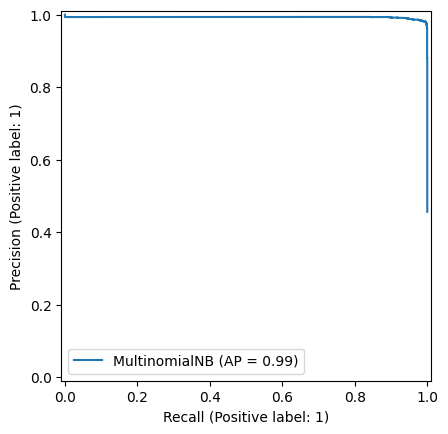

In [7]:
print("MULTINOMIAL CON UNIGRAMAS\n")
print(f"El alpha utilizado es: {mejorAlphaLocal:.4f}", end=" \n")

# Repito el anterior con su mejor alpha y lo muestro

classifier = MultinomialNB(alpha=mejorAlphaLocal, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

y_pred = classifier.predict(X_val)
f1_score=metrics.f1_score(y_val, y_pred)

# Imprime el F1-score en porcentaje con dos decimales para mayor legibilidad.
print(f"F1-score of the test: {100*f1_score:2.2f}%")

# Calcula la matriz de confusión para las predicciones en el conjunto de validación.
# La matriz de confusión muestra:
# - True Positives (Spam correctamente clasificado).
# - True Negatives (Ham correctamente clasificado).
# - False Positives (Ham clasificado como Spam).
# - False Negatives (Spam clasificado como Ham).
C=metrics.confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(C)

# Genera y muestra una curva precisión-recall basada en el clasificador, utilizando X_val e y_val.
# Esta curva permite evaluar el rendimiento del modelo al variar el umbral de decisión.
metrics.PrecisionRecallDisplay.from_estimator(classifier, X_val, y_val)

BERNOULLI, BIGRAMAS:

In [8]:
# Crea un vectorizador para convertir texto a características numéricas como bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit se encarga de crear el vocabulario con todas las palabras únicas presentes en los datos de entrada
# Transform se encarga de transformar los datos de entrada en un vector (numérico, para que el modelo pueda entender)
X = vectorizer.fit_transform(mails_train)

# Transform se encarga de transformar los datos previamente aprendidos en un vector con el mismo vocabulario
X_val = vectorizer.transform(mails_val)

porcentajeFin = 0.0
mejorPorcentajeLocal = 0.0
mejorAlphaLocal = 0.0

# Bucle para comprobar el alpha desde 0.1 hasta 1.0, yendo de 0.01 en 0.01 para obtener el mejor
for i in np.arange(0.1,1.0,0.01):
  # Se crea un clasificador Bayesiano Ingenuo con distribución de Bernoulli y el valor actual alpha
  classifier = BernoulliNB(alpha=i, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli

  # Entrena el modelo con los datos de entrenamiento
  classifier.fit(X,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

  # Predice etiquetas para los datos de validación
  y_pred = classifier.predict(X_val)

  # Calcula el F1-score (métrica de evaluación) para las predicciones
  f1_score=metrics.f1_score(y_val, y_pred)

  porcentaje = 100*f1_score
  #print(f"Porcentaje: {porcentaje:.2f}%", end=" \n")

  if (porcentaje > mejorPorcentajeLocal):
    mejorPorcentajeLocal = porcentaje
    mejorAlphaLocal = i
    if (mejorPorcentajeLocal > porcentajeTotal):
        porcentajeTotal = mejorPorcentajeLocal
        opcion_elegida="Bernoulli con bigrama"
        alphaFinal = i

Con el alpha más adecuado:

BERNOULLI CON BIGRAMAS

El alpha utilizado es: 0.1000 
F1-score of the test: 95.58%
Confusion Matrix:
[[2793  222]
 [  11 2518]]


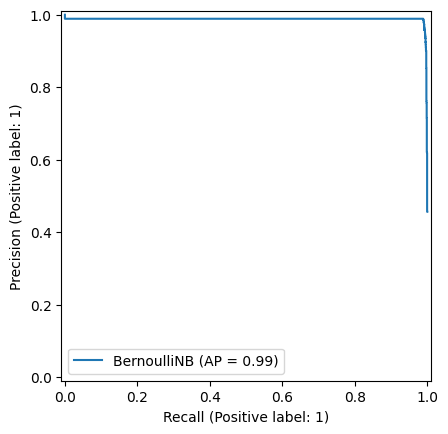

In [9]:
print("BERNOULLI CON BIGRAMAS\n")
print(f"El alpha utilizado es: {mejorAlphaLocal:.4f}", end=" \n")

# Repito el anterior con su mejor alpha y lo muestro

classifier = BernoulliNB(alpha=mejorAlphaLocal, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

y_pred = classifier.predict(X_val)
f1_score=metrics.f1_score(y_val, y_pred)

# Imprime el F1-score en porcentaje con dos decimales para mayor legibilidad.
print(f"F1-score of the test: {100*f1_score:2.2f}%")

# Calcula la matriz de confusión para las predicciones en el conjunto de validación.
# La matriz de confusión muestra:
# - True Positives (Spam correctamente clasificado).
# - True Negatives (Ham correctamente clasificado).
# - False Positives (Ham clasificado como Spam).
# - False Negatives (Spam clasificado como Ham).
C=metrics.confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(C)

# Genera y muestra una curva precisión-recall basada en el clasificador, utilizando X_val e y_val.
# Esta curva permite evaluar el rendimiento del modelo al variar el umbral de decisión.
metrics.PrecisionRecallDisplay.from_estimator(classifier, X_val, y_val)

MULTINOMIAL, BIGRAMA:

In [10]:
# Crea un vectorizador para convertir texto a características numéricas como bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit se encarga de crear el vocabulario con todas las palabras únicas presentes en los datos de entrada
# Transform se encarga de transformar los datos de entrada en un vector (numérico, para que el modelo pueda entender)
X = vectorizer.fit_transform(mails_train)

# Transform se encarga de transformar los datos previamente aprendidos en un vector con el mismo vocabulario
X_val = vectorizer.transform(mails_val)

porcentajeFin = 0.0
mejorPorcentajeLocal = 0.0
mejorAlphaLocal = 0.0

# Bucle para comprobar el alpha desde 0.1 hasta 1.0, yendo de 0.01 en 0.01 para obtener el mejor
for i in np.arange(0.1,1.0,0.01):
  # Se crea un clasificador Bayesiano Ingenuo con distribución de Multinomial y el valor actual alpha
  classifier = MultinomialNB(alpha=i, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli

  # Entrena el modelo con los datos de entrenamiento
  classifier.fit(X,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

  # Predice etiquetas para los datos de validación
  y_pred = classifier.predict(X_val)

  # Calcula el F1-score (métrica de evaluación) para las predicciones
  f1_score=metrics.f1_score(y_val, y_val)

  porcentaje = 100*f1_score
  #print(f"Porcentaje: {porcentaje:.2f}%", end=" \n")

  if (porcentaje > mejorPorcentajeLocal):
    mejorPorcentajeLocal = porcentaje
    mejorAlphaLocal = i
    if (mejorPorcentajeLocal > porcentajeTotal):
        porcentajeTotal = mejorPorcentajeLocal
        opcion_elegida="Multinomial con bigrama"
        alphaFinal = i



MULTINOMIAL CON BIGRAMAS

El alpha utilizado es: 0.1000 
F1-score of the test: 98.62%
Confusion Matrix:
[[3003   12]
 [  57 2472]]


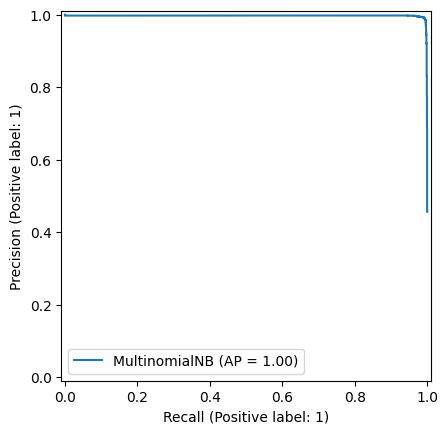

In [11]:
print("MULTINOMIAL CON BIGRAMAS\n")
print(f"El alpha utilizado es: {mejorAlphaLocal:.4f}", end=" \n")

# Repito el anterior con su mejor alpha y lo muestro

classifier = MultinomialNB(alpha=mejorAlphaLocal, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

y_pred = classifier.predict(X_val)
f1_score=metrics.f1_score(y_val, y_pred)

# Imprime el F1-score en porcentaje con dos decimales para mayor legibilidad.
print(f"F1-score of the test: {100*f1_score:2.2f}%")

# Calcula la matriz de confusión para las predicciones en el conjunto de validación.
# La matriz de confusión muestra:
# - True Positives (Spam correctamente clasificado).
# - True Negatives (Ham correctamente clasificado).
# - False Positives (Ham clasificado como Spam).
# - False Negatives (Spam clasificado como Ham).
C=metrics.confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(C)

# Genera y muestra una curva precisión-recall basada en el clasificador, utilizando X_val e y_val.
# Esta curva permite evaluar el rendimiento del modelo al variar el umbral de decisión.
metrics.PrecisionRecallDisplay.from_estimator(classifier, X_val, y_val)

In [12]:
print("La mejor opción es: ")
print(opcion_elegida)
print("El alpha utilizado para esa opción es: ")
print(alphaFinal)


La mejor opción es: 
Multinomial con bigrama
El alpha utilizado para esa opción es: 
0.1





---



---


---
VEMOS QUE LA MEJOR OPCIÓN ES MULTINOMIAL CON BIGRAMA, UTILIZANDO UN ALPHA DE 0.1000


---



---



---



Evaluación en los datos de test:
- F1-score: 0.98
- Precisión: 0.99
- Recall: 0.97
Matriz de Confusión en Test:
[[1463   37]
 [ 116 4384]]
Umbral óptimo para clasificación de spam: 0.000


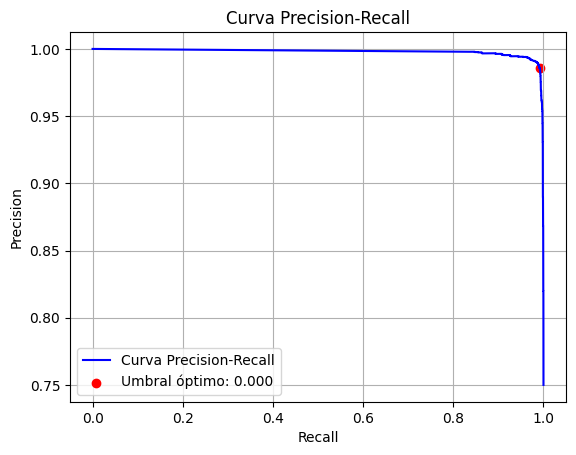

In [13]:
# Evaluación en los datos de test con el mejor modelo
if opcion_elegida == "Multinomial con bigrama" or opcion_elegida == "Bernoulli con bigrama":
  vectorizer = CountVectorizer(ngram_range=(2, 2))  # Instancia de bolsa de palabras con palabras individuales como características
  X_train = vectorizer.fit_transform(mails_train)               # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
  X_test = vectorizer.transform(mails_test)         # Cálculo de la bolsa de palabras con los datos de test

elif opcion_elegida == "Multinomial con unigrama" or opcion_elegida == "Bernoulli con unigrama":
  vectorizer = CountVectorizer(ngram_range=(1, 1))  # Instancia de bolsa de palabras con palabras individuales como características
  X_train = vectorizer.fit_transform(mails_train)               # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
  X_test = vectorizer.transform(mails_test)         # Cálculo de la bolsa de palabras con los datos de test

if opcion_elegida == "Multinomial con bigrama" or opcion_elegida == "Multinomial con unigrama":
  classifier = MultinomialNB(alpha=alphaFinal, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Multinomial
  classifier.fit(X_train,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

elif opcion_elegida == "Bernoulli con bigrama" or opcion_elegida == "Bernoulli con unigrama":
  classifier = BernoulliNB(alpha=alphaFinal, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
  classifier.fit(X_train,y_train) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

y_test_pred = classifier.predict(X_test)
f1_score_test=metrics.f1_score(y_test, y_test_pred)
precision_test = metrics.precision_score(y_test, y_test_pred)
recall_test = metrics.recall_score(y_test, y_test_pred)

# Mostrar las métricas finales
print(f"Evaluación en los datos de test:")
print(f"- F1-score: {f1_score_test:.2f}")
print(f"- Precisión: {precision_test:.2f}")
print(f"- Recall: {recall_test:.2f}")

# Matriz de confusión en test
C_test = metrics.confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusión en Test:")
print(C_test)

# Curva precisión-recall para los datos de test:

# Calcula las probabilidades para cada correo en los datos de test.
# predict_proba devuelve una matriz donde cada fila representa un correo y tiene dos columnas:
#   columna 0: probabilidad de que el correo sea ham
#   columna 1: probabilidad de que el correo sea spam
# Aquí seleccionamos la columna 1 porque nos interesa la probabilidad de que cada correo sea spam
probabilidades_test = classifier.predict_proba(X_test)[:, 1]

# Genera los valores de precisión, recall y los umbrales, a partir de las probabilidades que hemos predicho anteriormente
#   precision: lista con la precisión para diferentes valores de umbral
#   recall: lista con el recall para diferentes valores de umbral
#   umbral: lista de umbrales probados
# La curva precisión-recall muestra cómo cambian precisión y recall según el umbral.
precision, recall, umbral = metrics.precision_recall_curve(y_test, probabilidades_test)

# Encuentra el índice del umbral (np.argmax) que maximiza el balance entre recall y precisión
optimo_id = np.argmax(recall - (1 - precision))

# Guardamos el umbral óptimo
umbral_optimo = umbral[optimo_id]

print(f"Umbral óptimo para clasificación de spam: {umbral_optimo:.3f}")

# Graficar la curva Precision-Recall, y muestra cómo varía precisión (en el eje Y), y el
# recall (en el eje X), a medida que se ajusta el umbral
plt.plot(recall, precision, label="Curva Precision-Recall", color="blue")

# Punto rojo de umbral óptimo
plt.scatter(recall[optimo_id], precision[optimo_id], color="red", label=f"Umbral óptimo: {umbral_optimo:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Convertir y_test y y_test_pred a arrays de NumPy
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

# Calcular la distribución de clases
print("Distribución de y_test:")
print("Spam (1):", sum(y_test == 1))
print("Ham (0):", sum(y_test == 0))

print("Distribución de y_test_pred:")
print("Spam (1):", sum(y_test_pred == 1))
print("Ham (0):", sum(y_test_pred == 0))

Distribución de y_test:
Spam (1): 4500
Ham (0): 1500
Distribución de y_test_pred:
Spam (1): 4421
Ham (0): 1579




*   Hay 4500 correos etiquetados como spam (1) y 1500 etiquetados como ham (0).
*   El modelo clasificó 4422 correos como spam (1) y 1578 como ham (0).

In [15]:
# Clasificaciones Correctas e Incorrectas
true_positives = np.where((y_test == 1) & (y_test_pred == 1))[0]
false_positives = np.where((y_test == 0) & (y_test_pred == 1))[0]
true_negatives = np.where((y_test == 0) & (y_test_pred == 0))[0]
false_negatives = np.where((y_test == 1) & (y_test_pred == 0))[0]

# Mostrar ejemplos de clasificación
print("=== Ejemplos de Clasificación en Test ===\n")

# Ejemplos de verdaderos positivos (Spam correctamente clasificado)
if len(true_positives) > 0:
    print("Spam Clasificado Correctamente (True Positives):")
    for id in true_positives[:3]:
        print(f"- Correo {id + 1}:\n{mails_test[id][:300]}...\n")
else:
    print("No hay ejemplos de True Positives.\n")

# Ejemplos de falsos positivos (Ham clasificado como Spam)
if len(false_positives) > 0:
    print("Ham Clasificado como Spam (False Positives):")
    for id in false_positives[:3]:
        print(f"- Correo {id + 1}:\n{mails_test[id][:300]}...\n")
else:
    print("No hay ejemplos de False Positives.\n")

# Ejemplos de verdaderos negativos (Ham correctamente clasificado)
if len(true_negatives) > 0:
    print("Ham Clasificado Correctamente (True Negatives):")
    for id in true_negatives[:3]:
        print(f"- Correo {id + 1}:\n{mails_test[id][:300]}...\n")
else:
    print("No hay ejemplos de True Negatives.\n")

# Ejemplos de falsos negativos (Spam clasificado como Ham)
if len(false_negatives) > 0:
    print("Spam Clasificado como Ham (False Negatives):")
    for id in false_negatives[:3]:
        print(f"- Correo {id + 1}:\n{mails_test[id][:300]}...\n")
else:
    print("No hay ejemplos de False Negatives.\n")

=== Ejemplos de Clasificación en Test ===

Spam Clasificado Correctamente (True Positives):
- Correo 1:
Subject: auslaenderpolitik
lese selbst :
http : / / www . mjoelnirsseite . de / 2100 . htm...

- Correo 2:
Subject: can you believe this ?
you can make the difference
at around 5 a . m . , helicopters circled our village . later , four men wearing
sudanese military uniforms who had arrived on camels , horses and by cars
entered our house and took some of our properties , then set the house on
fire ....

- Correo 3:
Subject: 5 oo - 35 oo per day returning phone calls v
hello ,
baptiste atrophy compendia
emission monsoon road
hello ,
would you like to generate at least $ 1500 to $ 3500 per day just for returning 2 minute phone calls without any selling or explaining ?
this is not mlm and there are no board...

Ham Clasificado como Spam (False Positives):
- Correo 28:
Subject: ets : the next generation
click here for more information about " ets : the next generation " . . .
...

- Corr

**INFORME:**

En esta práctica he implementado un filtro de spam basado en el clasificador de Bayes Ingenuo utilizando unos datos proporcionados. El objetivo principal es desarrollar y evaluar el rendimiento de modelos entrenados con diferentes configuraciones (clasificadores Multinomial y Bernoulli y características basadas en unigramas y bigramas). A continuación vamos a analizar los resultados obtenidos:

Se probaron cuatro configuraciones principales:
1.   Bernoulli con unigrama.
2.   Multinomial con unigrama.
3.   Bernoulli con bigrama.
4.   Multinomial con bigrama.

Para cada configuración se ha obtenido el alpha (valor del parámetro suavizado de Laplace) dentro de un rango de 0.1 y 1.0. El motivo por el que elegí este rango, fue porque al hacer numerosas pruebas, observé que los números por encima del 1 hacía que disminuyese el porcentaje. Es por eso que elegí valores más pequeños para probar.

Finalmente seleccioné la configuración con el mayor F1-score en los datos de validación (y guardé su respectivo alpha).


*   **Métricas en los Datos de Validación**

    Para cada configuración, los F1-scores obtenidos en los datos de validación mostraron las siguientes conclusiones:

    - **Unigramas**: obtienen las características individuales de las palabras. Sin embargo, no consiguen tener el contexto completo en expresiones más complejas.
    - **Bigramas**: aunque pueden implicar un aumento en la dimensionalidad del modelo por tener que incluir combinacioens de palabras consecutivas, se obtuvieron mejores resultados ya que proporcionó un contexto adicional para reducir los falsos positivos y falsos negativos.

*   **Selección de la Mejor Configuración**

    De las cuatro configuraciones, la mejor fue Multinomial con bigrama, con un valor óptimo de alpha = 0.1. Esto se debe a que esta configuración consiguió el mejor balance entre precisión y recall.

*   **Métricas en los Datos de Test**
    Tras tener ya entrenados los datos, pasamos a evaluar las métricas con los datos de test.

    F1-score: 98%. El modelo es muy efectivo tanto en detectar spam como en mantener un número de error bajo de colocar spam en los correos ham.

    Precisión: 99%. El modelo comete muy pocos errores al clasificar correos ham como spam (falsos positivos).

    Recall: 98%. El modelo comete pocos errores al clasificar correos spam como ham (falsos negativos).

    Es preferible que haya un correo de spam como ham, a que haya un correo de ham en spam.
    
    Estos resultados muestran un buen rendimiento del modelo en cuanto a:
    - Precisión: el modelo identifica bastante bien los correos spam sin clasificar erróneamente demasiados correos ham como spam.
    - Recall: el modelo detecta la mayoría de los correos spam con un bajo número de falsos negativos.